<a href="https://colab.research.google.com/github/JungOhLee/GDL_pytorch/blob/shcho/shcho_chapter5_20200405_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import  tarfile
from torchsummary import summary as ptsum
import torch.autograd as autograd
# import png

from PIL import Image
from torch.autograd import Variable

import cv2

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import collections
from torch.autograd import Variable
import warnings
warnings.filterwarnings(action='ignore')

from zipfile import ZipFile

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
def convert(data):
    if isinstance(data, bytes):  return data.decode('ascii')
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return map(convert, data)
    return data

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
input_img_dir = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/'

In [0]:
input_img_dir_trainA = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_trainA.npy'
_trainA = np.load(input_img_dir_trainA)

input_img_dir_trainB = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_trainB.npy'
_trainB = np.load(input_img_dir_trainB)

input_img_dir_testA = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_testA.npy'
_testA = np.load(input_img_dir_testA)

input_img_dir_testB = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_testB.npy'
_testB = np.load(input_img_dir_testB)

In [0]:
trainA = _trainA.transpose(0,3,1,2)/255
trainB = _trainB.transpose(0,3,1,2)/255
testA = _testA.transpose(0,3,1,2)/255
testB = _testB.transpose(0,3,1,2)/255

## Architecture

In [0]:
class Generator_unet(nn.Module):
  def __init__(self, filters, unet_depth):
    super(Generator_unet, self).__init__()

    self.filters = filters
    self.unet_depth = unet_depth

    self.unet_down_layers = nn.Sequential()

    self.unet_dict_down = nn.ModuleDict()
    self.unet_dict_up = nn.ModuleDict()
    self.unet_dict_upsample = nn.ModuleDict()

    self.downsample_filters_list = []
    for i in range(self.unet_depth):
      in_filters = self.filters*(i+1)
      out_filters = self.filters*(i+2)
      conv = nn.Conv2d(in_filters, 
                        out_filters, 
                        kernel_size = 5, 
                        stride = 2, 
                        padding = 2
                        )
      self.unet_dict_down['Layer {}'.format(i+1)] = conv
      # print(out_filters)
      self.downsample_filters_list.append(out_filters)

    self.downsample_filters_list.reverse()

    for i, j in zip(range(self.unet_depth-1), self.downsample_filters_list):
      if i==0:
        in_filters = j
        prev_j = j
      else:
        in_filters = j * 2
        prev_j = j
      out_filters = self.filters*(self.unet_depth-i)
      conv = nn.Conv2d(in_filters, 
                        out_filters, 
                        kernel_size = 5, 
                        stride = 1, 
                        padding = 2
                        )
      self.unet_dict_up['Layer {}'.format(i+1)] = conv

    for i in range(self.unet_depth):
      conv = nn.Upsample(scale_factor=2)
      self.unet_dict_upsample['Layer {}'.format(i+1)] = conv
    
  def forward(self, x):

    d_output_dict = {}
    for i in range(self.unet_depth):
      d = self.unet_dict_down['Layer {}'.format(i+1)]
      x = d(x)

      d_output_dict[i] = x

    # print(x.shape)
    for i in range(self.unet_depth-1):
      u_upsample = self.unet_dict_upsample['Layer {}'.format(i+1)]
      u = self.unet_dict_up['Layer {}'.format(i+1)]
      x = u_upsample(x)
      # print(x.shape)
      x = u(x)
      d_to_concat = d_output_dict[self.unet_depth-i-2]

      print(x.shape, d_to_concat.shape)

      x = torch.cat([x, d_to_concat], dim=1)

      print(x.shape)

      print('\n')
    
    u = self.unet_dict_up['Layer {}'.format(self.unet_depth)]

    x = u(x)

    return x, d_output_dict

In [0]:
temp = Generator_unet(3, 5).to(device)

In [0]:
_x_batch = trainA[:10]

In [246]:
_x_batch.shape

(10, 3, 256, 256)

In [0]:
x_batch = torch.from_numpy(_x_batch).float().to(device)

In [0]:
upsample_layer = nn.Upsample(scale_factor=2)

In [338]:
temp.unet_dict_up

ModuleDict(
  (Layer 1): Conv2d(18, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Layer 2): Conv2d(36, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Layer 3): Conv2d(24, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Layer 4): Conv2d(12, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [358]:
output, d_output_dict = temp(x_batch)

torch.Size([10, 15, 16, 16]) torch.Size([10, 15, 16, 16])
torch.Size([10, 30, 16, 16])


torch.Size([10, 12, 32, 32]) torch.Size([10, 12, 32, 32])
torch.Size([10, 24, 32, 32])


torch.Size([10, 9, 64, 64]) torch.Size([10, 9, 64, 64])
torch.Size([10, 18, 64, 64])


torch.Size([10, 6, 128, 128]) torch.Size([10, 6, 128, 128])
torch.Size([10, 12, 128, 128])




KeyError: ignored

In [0]:
a = [1,2,3,4,5]

In [0]:
a.reverse()

In [324]:
a

[5, 4, 3, 2, 1]

In [299]:
output.shape

torch.Size([10, 18, 8, 8])

In [300]:
d_output_dict.keys()

dict_keys([0, 1, 2, 3, 4])

In [301]:
d_output_dict[4].shape

torch.Size([10, 18, 8, 8])

In [304]:
torch.cat([output, output], dim=1).shape

torch.Size([10, 36, 8, 8])

In [277]:
output.shape

torch.Size([50, 3, 128, 128])

In [266]:
d_output_dict[0].shape, d_output_dict[1].shape, d_output_dict[2].shape, d_output_dict[3].shape, d_output_dict[4].shape

(torch.Size([10, 6, 128, 128]),
 torch.Size([10, 12, 64, 64]),
 torch.Size([10, 24, 32, 32]),
 torch.Size([10, 48, 16, 16]),
 torch.Size([10, 96, 8, 8]))

In [214]:
d_output_list[0].shape, d_output_list[1].shape, d_output_list[2].shape, d_output_list[3].shape, d_output_list[4].shape

(torch.Size([10, 6, 128, 128]),
 torch.Size([10, 12, 64, 64]),
 torch.Size([10, 24, 32, 32]),
 torch.Size([10, 48, 16, 16]),
 torch.Size([10, 96, 8, 8]))

In [215]:
output.shape

torch.Size([10, 96, 8, 8])

In [0]:
class Discriminator_PT(nn.Module): # GAN Pytorch
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , optimiser
        , z_dim
        , activation_function
        ):
        
        super(Discriminator_PT, self).__init__()

        self.name = 'gan'

        self.input_dim = input_dim
        
        ## discriminator
        self.discriminator_conv_filters_input = [input_dim[0]] + discriminator_conv_filters[:-1]
        self.discriminator_conv_filters_output = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate
        self.activation_function = activation_function

        
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)

        # initializer
        self.weight_init = torch.normal(mean=torch.Tensor([0.]), std=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0
        
        self.discriminator_conv_layers = nn.Sequential()
        self.discriminator_output_shape = collections.OrderedDict()
        
        self.discriminator_output_shape['Input'] = self.input_dim

        self._build_discriminator()

    def _build_discriminator(self):

        print('Build Discriminator')
        current_layer_name = 'Input'
        current_input_shape = self.discriminator_output_shape[current_layer_name]
        
        for i in range(self.n_layers_discriminator):
            
            current_filter, input_H, input_W = current_input_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)
            
            kernel_H, kernel_W = self.discriminator_conv_kernel_size[i]
            stride_H, stride_W  = self.discriminator_conv_strides[i]
            
            _output_H = int((input_H-kernel_H)/stride_H) + 1 # int 논리 맞는지 확인
            _output_W = int((input_W-kernel_W)/stride_W) + 1
            
            target_output_H = np.ceil(input_H/stride_H)
            target_output_W = np.ceil(input_W/stride_W)
            
            if target_output_H != _output_H:
                padding_H = int(np.ceil(((target_output_H-1)*stride_H-input_H+kernel_H)/2))
            else:
                padding_H = 0
                
            if target_output_W != _output_W:
                padding_W = int(np.ceil(((target_output_W-1)*stride_W-input_W+kernel_W)/2))
            else:
                padding_W = 0
            
            output_H = int((input_H-kernel_H+2*padding_H)/stride_H) + 1
            output_W = int((input_W-kernel_W+2*padding_W)/stride_W) + 1
            
            print(output_H, output_W)
            
            self.discriminator_output_shape[current_layer_name] = [self.discriminator_conv_filters_output[i], output_H, output_W]
            current_input_shape = self.discriminator_output_shape[current_layer_name]
            
            conv = nn.Conv2d(
                        self.discriminator_conv_filters_input[i]
                        , self.discriminator_conv_filters_output[i]
                        , kernel_size = self.discriminator_conv_kernel_size[i]
                        , stride = self.discriminator_conv_strides[i]
                        , padding = (padding_H, padding_W)
#                         , kernel_initializer = self.weight_init
                        )
            # conv.weight.data.apply_(self.weight_init)

            self.discriminator_conv_layers.add_module(
                current_layer_name,
                conv
            )

            if self.discriminator_batch_norm_momentum and i > 0:
                self.discriminator_conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                            nn.BatchNorm2d(self.discriminator_conv_filters_output[i],
                                                          momentum=self.discriminator_batch_norm_momentum))

            self.discriminator_conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())

            if self.discriminator_dropout_rate:
                self.discriminator_conv_layers.add_module('Layer {} Dropout2d'.format(i), nn.Dropout2d(p=self.discriminator_dropout_rate))
            
        self.discriminator_cnn_output_shape = current_input_shape
        
        self.discriminator_flattened_shape = np.prod(self.discriminator_cnn_output_shape)

        
        ## Flatten 층 생성
        ## 역시 이 전에 reshaping은 forward에서
        self.discriminator_flattened = nn.Linear(self.discriminator_flattened_shape, 1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.discriminator_conv_layers(x)
        x = x.reshape(x.size()[0],-1)
        
#         print(x.shape)
        
        x = self.discriminator_flattened(x)

        if self.activation_function == 'Sigmoid':
          x = self.Sigmoid(x)
        
        
        return x


In [0]:
## generator 는 똑같다.

class Generator_PT(nn.Module): # GAN Pytorch
    def __init__(self
        , generator_initial_dense_layer_size
        , input_dim
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        , discriminator_output_shape
        , discriminator_cnn_output_shape
        ):
        
        super(Generator_PT, self).__init__()

        # Necessary information from discriminator
        self.discriminator_output_shape = discriminator_output_shape
        self.discriminator_cnn_output_shape = discriminator_cnn_output_shape
        
        self.name = 'gan'
        self.input_dim = input_dim
        
        ## generator
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters_input = [self.generator_initial_dense_layer_size[0]] + generator_conv_filters[:-1]
        self.generator_conv_filters_output = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.z_dim = z_dim

        self.n_layers_generator = len(generator_conv_filters)

        # initializer
        self.weight_init = torch.normal(mean=torch.Tensor([0.]), std=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0
                
        self.generator_conv_layers = nn.Sequential()
        self.generator_output_shape = collections.OrderedDict()
        
        self.generator_initial_layers = nn.Sequential()
        
        self.generator_output_shape['Input'] = self.input_dim
        self.generator_output_shape['Input'] = self.generator_initial_dense_layer_size


        self._build_generator()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_generator(self):

        print('Build Generator')
        ### THE generator

        self.generator_initial_layers.add_module('Layer Generator Input', 
                                            nn.Linear(self.z_dim, np.prod(self.generator_initial_dense_layer_size)))

        self.generator_initial_layers.add_module('Layer Generator Input LeakyReLU', nn.LeakyReLU())
        
        if self.generator_dropout_rate:
            self.generator_initial_layers.add_module('Layer Generator Input Dropout2d', nn.Dropout2d(p=self.generator_dropout_rate))
            
        # 이건 forward가서
#         x = Reshape(self.generator_initial_dense_layer_size)(x)
        
        current_layer_name = 'Input'
        current_input_shape = self.generator_output_shape[current_layer_name]
        
        discriminator_conv_layer_name_list = []
        
#         print(self.discriminator_output_shape)
        
        for item in self.discriminator_output_shape:
            discriminator_conv_layer_name_list.append(item)
        discriminator_conv_layer_name_list.reverse()

#         print(discriminator_conv_layer_name_list)
        for i, discriminator_layer_name in zip(range(self.n_layers_generator), discriminator_conv_layer_name_list[1:]):
            
#             print(discriminator_layer_name)
            
            discriminator_layer_shape = self.discriminator_output_shape[discriminator_layer_name]
            
            current_filter, input_H, input_W = discriminator_layer_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)

        
            if self.generator_upsample[i] == 2:
                
                current_filter, input_H, input_W = current_input_shape
                
                input_H = input_H*self.generator_upsample[i]
                input_W = input_W*self.generator_upsample[i]
                
                current_layer_name = 'Layer {} Conv2d'.format(i)

                kernel_H, kernel_W = self.generator_conv_kernel_size[i]
                stride_H, stride_W  = self.generator_conv_strides[i]

                _output_H = int((input_H-kernel_H)/stride_H) + 1
                _output_W = int((input_W-kernel_W)/stride_W) + 1

                target_output_H = int(input_H/stride_H)
                target_output_W = int(input_W/stride_W)

                if target_output_H != _output_H:
                    padding_H = int(np.ceil(((target_output_H-1)*stride_H-input_H+kernel_H)/2))
                else:
                    padding_H = 0

                if target_output_W != _output_W:
                    padding_W = int(np.ceil(((target_output_W-1)*stride_W-input_W+kernel_W)/2))
                else:
                    padding_W = 0

                output_H = int((input_H-kernel_H+2*padding_H)/stride_H) + 1
                output_W = int((input_W-kernel_W+2*padding_W)/stride_W) + 1
                
                self.generator_output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                current_input_shape = self.generator_output_shape[current_layer_name]
                

                self.generator_conv_layers.add_module('Layer {} Upsample'.format(i),
                                            nn.Upsample(scale_factor=self.generator_upsample[i])
                                           )
                

                self.generator_conv_layers.add_module(
                    current_layer_name,
                    nn.Conv2d(
                            self.generator_conv_filters_input[i]
                            , self.generator_conv_filters_output[i]
                            , kernel_size = self.generator_conv_kernel_size[i]
                            , stride = self.generator_conv_strides[i]
                            , padding = (padding_H, padding_W)
    #                         , kernel_initializer = self.weight_init
                            )
                )
                
            else:
                
                # defining size
                current_filter, input_H, input_W = current_input_shape
                current_layer_name = 'Layer {} Conv2d'.format(i)

                kernel_H, kernel_W = self.generator_conv_kernel_size[i]
                stride_H, stride_W = self.generator_conv_strides[i]

                target_output_H = max(input_H*stride_H,discriminator_layer_shape[1])
                target_output_W = max(input_W*stride_W,discriminator_layer_shape[2])

                padding_output_padding_H = (input_H - 1) * stride_H + (kernel_H - 1) + 1 - target_output_H
                padding_output_padding_W = (input_W - 1) * stride_W + (kernel_W - 1) + 1 - target_output_W
                
                if padding_output_padding_H%2==0:
                    output_padding_H = 0
                    padding_H = int(padding_output_padding_H/2)
                else:
                    output_padding_H = max(stride_H-1,0)
                    padding_H = int((padding_output_padding_H+output_padding_H)/2)
                    
                if padding_output_padding_W%2==0:
                    output_padding_W = 0
                    padding_W = int(padding_output_padding_W/2)
                else:
                    output_padding_W = max(stride_W-1,0)
                    padding_W = int((padding_output_padding_W+output_padding_W)/2)

                # padding_H = max(0, padding_H)
                # padding_W = max(0, padding_W)
                    
                output_H = (input_H-1)*stride_H + (kernel_H-1)+1 - 2 * padding_H + output_padding_H
                output_W = (input_W-1)*stride_W + (kernel_W-1)+1 - 2 * padding_W + output_padding_W

                self.generator_output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                current_input_shape = self.generator_output_shape[current_layer_name]
                
                # print('\n')
                # print(output_H, target_output_H, padding_H, output_padding_H, stride_H, kernel_H)

                # self.output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                # current_input_shape = self.output_shape[current_layer_name]

                self.generator_conv_layers.add_module(current_layer_name,
                                nn.ConvTranspose2d(self.generator_conv_filters_input[i]
                                        , self.generator_conv_filters_output[i]
                                        , kernel_size = self.generator_conv_kernel_size[i]
                                        , stride = self.generator_conv_strides[i]
                                        , padding = (padding_H, padding_W)
                                        , output_padding = (output_padding_H, output_padding_W)
                                        ))

            print(output_H, output_W, padding_H, padding_W)
                
            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    self.generator_conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                                nn.BatchNorm2d(self.generator_conv_filters_output[i],
                                                              momentum=self.generator_batch_norm_momentum))

                self.generator_conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())
                    
                
            # else:

            self.tanh = nn.Tanh()


        # 이 부분도 forward로
#         generator_output = x

#         self.generator = Model(generator_input, generator_output)


    def forward(self, x):
        
        
        x = self.generator_initial_layers(x)
        # print(x.shape)
        
        x = x.reshape([x.size()[0]]+list(self.generator_initial_dense_layer_size))
        
        x = self.generator_conv_layers(x)
        x = self.tanh(x)
        
        return x



In [0]:
z_dim = 100

In [0]:
input_dim = (3, 32, 32)

In [0]:
activation_function = 'Sigmoid'

In [0]:
activation_function = 'WGAN'

In [0]:
activation_function = 'WGANGP'

In [0]:
if activation_function == 'Sigmoid':
  discriminator_learning_rate = 0.0008
  generator_learning_rate = 0.0004
else:
  discriminator_learning_rate = 0.00005
  generator_learning_rate = 0.00005

device = 'cpu'

In [0]:
Discriminator = Discriminator_PT(
    input_dim = input_dim
    , discriminator_conv_filters = [32,64,128,128]
    , discriminator_conv_kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    , discriminator_conv_strides = [(2,2),(2,2),(2,2),(1,1)]
    , discriminator_batch_norm_momentum = 0.5
    , discriminator_activation = 'relu'
    , discriminator_dropout_rate = 0.4
    , discriminator_learning_rate = discriminator_learning_rate
    , optimiser = 'rmsprop'
    , z_dim = z_dim
    , activation_function = activation_function
    ).to(device)

Build Discriminator
16 16
8 8
4 4
4 4


In [0]:
Generator = Generator_PT(
    input_dim = input_dim
    , generator_initial_dense_layer_size = (128, 4, 4)
    , generator_upsample = [2,2, 2, 1]
    , generator_conv_filters = [128,64, 64,3]
    , generator_conv_kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    , generator_conv_strides = [(1,1),(1,1), (1,1), (1,1)]
    , generator_batch_norm_momentum = 0.8
    , generator_dropout_rate = 0.25
    , generator_activation = 'relu'
    , generator_learning_rate = generator_learning_rate
    , optimiser = 'rmsprop'
    , z_dim = z_dim
    , discriminator_output_shape = Discriminator.discriminator_output_shape
    , discriminator_cnn_output_shape = Discriminator.discriminator_cnn_output_shape
    ).to(device)

Build Generator
8 8 2 2
16 16 2 2
32 32 2 2
32 32 2 2


## 학습

In [0]:
Discriminator.train()
Generator.train()
print('Train mode')

Train mode


In [0]:
# Binary Cross Entropy loss
criterion = nn.BCELoss().to(device)

# 생성자의 매개 변수를 최적화하는 Adam optimizer
G_optimizer = optim.RMSprop(Generator.parameters(), lr=Generator.generator_learning_rate)
# 구분자의 매개 변수를 최적화하는 Adam optimizer
D_optimizer = optim.RMSprop(Discriminator.parameters(), 
                            lr=Discriminator.discriminator_learning_rate)

# optim.RMSprop
# optim.Adam

In [0]:
x_train_pt = torch.from_numpy(x_train).float().to(device)

In [0]:
EPOCHS = 1

In [0]:
batch_size = 128

In [0]:
for epoch in range(EPOCHS):
    
    for real_data in tqdm(DataLoader(x_train_pt, batch_size = batch_size, shuffle=True)):
      pass

In [0]:
EPOCHS = 5000

## activation_function

이것이 'None'이면 WGAN이다.

In [0]:
print(activation_function)

WGANGP


In [0]:
CLIP_THRESHOLD = 0.01

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates.float())
    fake = torch.ones(real_samples.shape[0], 1).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

```
D, real_samples, fake_samples = Discriminator, real_data.data, fake_data.data

alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
# Get random interpolation between real and fake samples
interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
d_interpolates = D(interpolates.float())
fake = torch.ones(real_samples.shape[0], 1).to(device)
# Get gradient w.r.t. interpolates
gradients = autograd.grad(
    outputs=d_interpolates,
    inputs=interpolates,
    grad_outputs=fake,
    create_graph=True,
    retain_graph=True,
    only_inputs=True,
)[0]
gradients = gradients.view(gradients.size(0), -1)
gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
```

In [0]:
if activation_function == 'Sigmoid':
  discriminator_train_number = 1
else:
  discriminator_train_number = 5

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

## Clipping 시키는 예시

https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_clipping.py

In [0]:
# Loss weight for gradient penalty
lambda_gp = 10

In [0]:
print(activation_function)

WGANGP


In [0]:
restart_epoch = 0

In [0]:
try:
  restart_epoch = epoch
except:
  restart_epoch = 0

for epoch in range(restart_epoch, EPOCHS):
  
  total_D_loss = 0
  total_G_loss = 0
  
  batch_count_for_generator = 0
  # for real_data in tqdm(DataLoader(x_train_pt, batch_size = batch_size, shuffle=True)):
  for real_data in DataLoader(x_train_pt, batch_size = batch_size, shuffle=True):
    # print(batch_count_for_generator)
    real_data_shape = real_data.shape[0]

    if real_data_shape!=batch_size:
      continue

    target_real = Variable(torch.ones(real_data_shape, 1)).float().to(device)

    ## 판별자
    for p in Discriminator.parameters():
      p.requires_grad = True  # to avoid computation
    for p in Generator.parameters():
      p.requires_grad = False  # to avoid computation
    D_optimizer.zero_grad()
    Discriminator.zero_grad()

    if activation_function == 'WGAN':
      for p in Discriminator.parameters():
        p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)

    D_result_from_real = Discriminator(real_data)
    z = (torch.randn((real_data_shape, z_dim))).to(device)
    fake_data = Generator(z)
    D_result_from_fake = Discriminator(fake_data)
    
    if activation_function == 'Sigmoid':
      target_fake = Variable(torch.zeros(real_data_shape, 1)).float().to(device)

      D_loss_real = criterion(D_result_from_real, target_real)
      D_loss_fake = criterion(D_result_from_fake, target_fake)

    else:
      target_fake = Variable(torch.ones(real_data_shape, 1)).float().to(device)

      # D_loss_real = (D_result_from_real * target_real).mean()
      D_loss_real = torch.mean(D_result_from_real)
      # from fake는 fake데이터를 discriminator가 평가한것. 
      # 이것에 target_fake를 곱하면, 
      # D_loss_fake = (D_result_from_fake * target_fake).mean()
      D_loss_fake = torch.mean(D_result_from_fake)

    if activation_function == 'WGANGP':
      gradient_penalty = compute_gradient_penalty(Discriminator, real_data.data, fake_data.data)
    else:
      gradient_penalty = torch.from_numpy(np.array([0])).to(device)

    if activation_function == 'Sigmoid':
      D_loss = D_loss_real + D_loss_fake
    elif activation_function == 'WGAN':
      D_loss = -1 * (D_loss_real - D_loss_fake)
    elif activation_function == 'WGANGP':
      D_loss = -1 * (D_loss_real - D_loss_fake) + lambda_gp * gradient_penalty

    # Discriminator.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Clipping weights
    # if activation_function == 'WGAN':
    #   for temp_layer in Discriminator.discriminator_conv_layers:
    #     if hasattr(temp_layer, 'weight'):
    #       for temp_p in temp_layer02.parameters():
    #         temp_p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)
    #   for temp_p in Discriminator.discriminator_flattened.parameters():
    #     temp_p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)
    


    if activation_function == 'Sigmoid':
      batch_count_for_generator = 0

    # Discriminator.train()
    # Generator.train()

    if batch_count_for_generator%5==0:
      # print('generator',batch_count_for_generator)
      for p in Discriminator.parameters():
        p.requires_grad = False  # to avoid computation
      for p in Generator.parameters():
        p.requires_grad = True  # to avoid computation
      G_optimizer.zero_grad()
      Generator.zero_grad()
      batch_count_for_generator = 0

      ## 생성자

      z = (torch.randn((real_data_shape, 100))).to(device)

      fake_data = Generator(z)

      D_result_from_fake = Discriminator(fake_data)

      if activation_function == 'Sigmoid':
        G_loss = criterion(D_result_from_fake, target_real)
      else:
        # G_loss = -1 * (D_result_from_fake * target_real).mean()
        G_loss = -1 * torch.mean(D_result_from_fake)

      G_loss.backward()
      G_optimizer.step()

      total_G_loss+=G_loss.item()

    total_D_loss+=D_loss.item()
    batch_count_for_generator+=1
    
    # print('\t', D_loss.item())
    # print('\t', G_loss.item())

  total_D_loss_numeric = round(total_D_loss,6)
  total_G_loss_numeric = round(total_G_loss,6)

  print_str = str(epoch) + ' ' + str(total_D_loss_numeric) + ' ' + str(total_G_loss_numeric)

  print(print_str)

  if epoch%10==0:
    try:
      torch.save(Discriminator.state_dict(), './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/trained_models/Discriminator_{}.pt'.format(activation_function))
      torch.save(Generator.state_dict(), './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/trained_models/Generator_{}.pt'.format(activation_function))

      Generator.eval()
      for i in range(10):
        generated_image = Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0)
        generated_image02 = (((generated_image - generated_image.min())/((generated_image - generated_image.min()).max()))*255).astype(int)
        img = Image.fromarray(np.uint8((generated_image02)))
        img.save('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/fig/image_{}_{}.png'.format(activation_function, i))
      Generator.train()
      
    except:
      pass

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1 -169.334716 36.396272
2 -233.969001 35.826734
3 -410.738574 48.025122
4 -724.77668 73.798481
5 -947.564746 88.185338
6 78.759503 80.88313
7 16.816731 56.14915
8 -42.39184 56.96152
9 -68.791103 63.169453
10 -97.939616 61.872069
11 -125.486708 55.59266
12 -173.485626 57.355412
13 -210.25009 58.675388
14 -204.294724 55.494898
15 -11.446121 36.855808
16 -24.364969 41.501018
17 -44.130873 42.683252
18 -58.642381 48.465553
19 -50.118582 42.91917
20 -46.737033 40.669711
21 -66.035759 35.087871
22 -40.79384 35.498149
23 -58.229816 31.005201
24 -78.142905 34.189741
25 -70.70925 29.548682
26 -78.035837 28.703191
27 -88.476029 27.718298
28 -85.27608 24.013015
29 -82.762053 20.239281
30 -88.798384 21.287295
31 -89.818392 20.185746
32 -93.874537 21.18656
33 -100.438616 22.962656
34 -95.892794 21.318297
35 -80.893057 23.393411
36 -6.874273 9.76158
37 -24.41019 16.326273
38 -29.372256 11.890822
39 -40.825108 12.064406
40 -33.756845 9.163119
41 -30.693484 7.343691

## GAN

In [0]:
# Generator.eval()
# generated_image = Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0)
# generated_image02 = (((generated_image - generated_image.min())/((generated_image - generated_image.min()).max()))*255).astype(int)
# img = Image.fromarray(np.uint8((generated_image02)))
# Generator.train()
# try:
#   img.save('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/fig/image.png')
# except:
#   pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


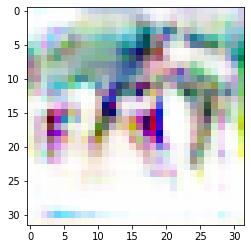

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()

## WGAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


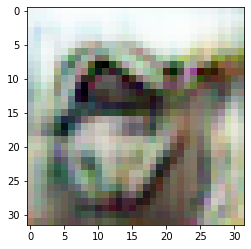

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()
print(1)

## WGAN-GP

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()
print(1)